# CELF and Social Score Network Visualization

In [26]:
import snap 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import networkx as nx
import csv 

from datetime import datetime
from matplotlib.pyplot import loglog 
from scipy import optimize
from networkx.algorithms.community import greedy_modularity_communities

from modifiedSocialScore import GenerateGraph, GenerateDirectedNxGraph, GeneratePrunedDirectedGraph

%matplotlib inline

In [27]:
#
# Load adjacency list as a pandas dataframe 
#
df, _ = GenerateGraph(filename='/home/merchantsameer2014/project/dnc-temporalGraph/out.dnc-temporalGraph')

In [28]:
#
# Build a networkx directed multigraph 
#   - Edge represents src sent an email to destination 
#
GNx = GenerateDirectedNxGraph(df)

In [29]:
# 
# Build an networkx undirected graph of nodes that have exchanged more than 4 emails 
#
uGNx = GeneratePrunedDirectedGraph(GNx, N=0)
#uGNx.remove_edges_from(nx.selfloop_edges(uGNx))

## Connected Components 

In [30]:
connectedComponents = nx.connected_component_subgraphs(uGNx)
numConnectedComponents = nx.number_connected_components(uGNx)
print "Email Network has: %r connected compoents" % numConnectedComponents
ccSubGraphs = [uGNx.subgraph(cc).copy() for cc in connectedComponents]
ccSize = [len(c) for c in sorted(nx.connected_components(uGNx), key=len, reverse=True)]
print "Size of largest connected component: %r" % max(ccSize)
SCC = max(nx.connected_component_subgraphs(uGNx), key=len)
print "Average Shortest Path legnth in Largest Connected component in email network: %r" % \
(nx.average_shortest_path_length(SCC))

Email Network has: 41 connected compoents
Size of largest connected component: 1833
Average Shortest Path legnth in Largest Connected component in email network: 3.369467930254886


## Egonet analysis of top N nodes 

    1. Nodes ranked based on social score... 
    2. Nodes picked by CELF

In [31]:
#
# Load CELF nodes 
#
topCELFNodes = list()
with open('../results/CELF population 100k runs.txt', 'r') as fd:
    print fd.readline()
    fd.readline()
    reader = csv.reader(fd, delimiter='\t')  
    for row in reader:
        #print row
        topCELFNodes.append(int(row[0]))

P_infect = 0.3 P_initial_infect = 0.001 Runs per marginal node = 100000



In [57]:
#
# Load social score nodes 
#
socialNodes = list()
topN = len(topCELFNodes)

with open('socialScore_unpruned.txt', 'r') as fd:
    reader = csv.reader(fd, delimiter='\t')            
    for row in reader:
        #print row
        socialNodes.append((row[0], row[1]))  
        
topSocialNodes = [ int(node) for (node, _) in socialNodes[:topN]]
allSocialNodes = [ int(node) for (node, _) in socialNodes]

In [172]:
socialScoreDict = dict()
scores = [ float(score) for (_, score) in socialNodes]
minScore = min(scores)
maxScore = max(scores)

for node, score in socialNodes:
    socialScoreDict[int(node)] = (float(score) - minScore)/maxScore


In [33]:
#
# Number of Social Nodes overlapping with Nodes selected by CELF
#
topCELFNodeSet = set(topCELFNodes)
topSocialNodeSet = set(topSocialNodes)
print topSocialNodes[:5]
print topCELFNodes[:5]

print "Number of nodes in common: %r (total:%r)" % (len(topSocialNodeSet.intersection(topCELFNodeSet)), len(topSocialNodeSet))

[1874, 1258, 999, 1669, 511]
[1874, 1669, 453, 1706, 1159]
Number of nodes in common: 31 (total:50)


In [34]:
# 
# Compute Egnonet for top odes based on Social Score 
#
topSocialNodeEgonet= dict()
topSocialNodeEgoNetNodes = dict()

for i, node in enumerate(topSocialNodes):
    topSocialNodeEgonet[i] = nx.ego_graph(uGNx, node, radius=1, undirected=True)   
    #
    # Generate list of egonet Nodes for each social scode node 
    #
    topSocialNodeEgoNetNodes[i] = set(topSocialNodeEgonet[i].nodes)
       

In [35]:
topSocialNodeOverlap = list()
topSocialNodeUnion = list()
egoNetNodes = set()
for i in range(len(topSocialNodes)-1):
    common_nodes = topSocialNodeEgoNetNodes[i].intersection(topSocialNodeEgoNetNodes[i+1])
    min_nodes = min(len(topSocialNodeEgoNetNodes[i]), len(topSocialNodeEgoNetNodes[i+1]))
    frac = float(len(common_nodes))/float(min_nodes)
    topSocialNodeOverlap.append(frac)
    egoNetNodes = egoNetNodes.union(topSocialNodeEgoNetNodes[i])
    topSocialNodeUnion.append(len(egoNetNodes))

In [36]:
# 
# Compute Egnonet for top odes based on Social Score 
#
topCELFNodeEgoNet= dict()
topCELFNodeEgoNetNodes = dict()

for i, node in enumerate(topCELFNodes):
    topCELFNodeEgoNet[i] = nx.ego_graph(uGNx, node, radius=1, undirected=True)   
    #
    # Generate list of egonet Nodes for each social scode node 
    #
    topCELFNodeEgoNetNodes[i] = set(topCELFNodeEgoNet[i].nodes)
       

In [37]:
topCELFNodesOverlap = list()
topCELFNodeUnion = list()
egoNetNodes = set()

for i in range(len(topCELFNodes)-1):
    common_nodes = topCELFNodeEgoNetNodes[i].intersection(topCELFNodeEgoNetNodes[i+1])
    min_nodes = min(len(topCELFNodeEgoNetNodes[i]), len(topCELFNodeEgoNetNodes[i+1]))
    frac = float(len(common_nodes))/float(min_nodes)
    topCELFNodesOverlap.append(frac)
    egoNetNodes = egoNetNodes.union(topCELFNodeEgoNetNodes[i])
    topCELFNodeUnion.append(len(egoNetNodes))


In [38]:
socialNodeEgoNetDistribution = list()
totalEgoNetSize = 0.0
for i in range(topN):
    egoNetSize = len(list(topSocialNodeEgonet[i].nodes))
    socialNodeEgoNetDistribution.append(egoNetSize)
    totalEgoNetSize += float(egoNetSize)
    
avgEgoNetSize = totalEgoNetSize/topN
print "Average Egonet size for top %d Social Score Nodes: %r, (Max:%r, min:%r)" % \
(topN, avgEgoNetSize, max(socialNodeEgoNetDistribution), min(socialNodeEgoNetDistribution))


Average Egonet size for top 50 Social Score Nodes: 75.82, (Max:403, min:2)


In [39]:
CELFNodeEgoNetDistribution = list()
totalEgoNetSize = 0.0
for i in range(topN):
    egoNetSize = len(list(topCELFNodeEgoNet[i].nodes))
    CELFNodeEgoNetDistribution.append(egoNetSize)
    totalEgoNetSize += float(egoNetSize)
    
avgEgoNetSize = totalEgoNetSize/topN
print "Average Egonet size for top %d CELF Nodes: %r, (Max:%r, min:%r)" % \
(topN, avgEgoNetSize, max(CELFNodeEgoNetDistribution), min(CELFNodeEgoNetDistribution))

Average Egonet size for top 50 CELF Nodes: 74.9, (Max:403, min:10)


In [40]:
celfSelected = topCELFNodeSet - topSocialNodeSet

[12, 14, 16, 20, 23, 24, 27, 28, 29, 34, 35, 36, 38, 39, 40, 43, 44, 47, 48]
Nodes CELF picked that aren't in top 50 Social Score set 
[1274, 246, 1377, 1151, 350, 1876, 691, 1906, 547, 1254, 390, 419, 1952, 329, 1510, 1500, 829, 841, 24]


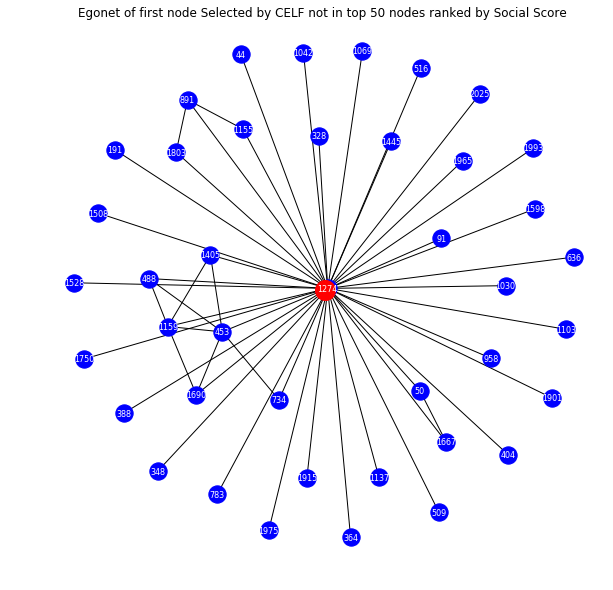

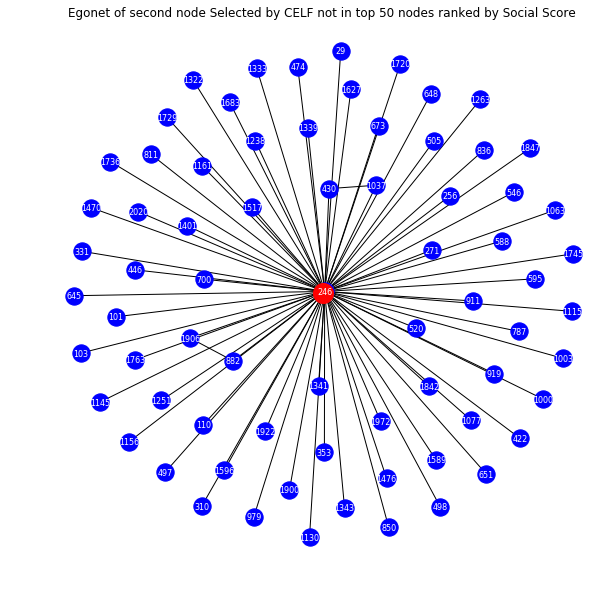

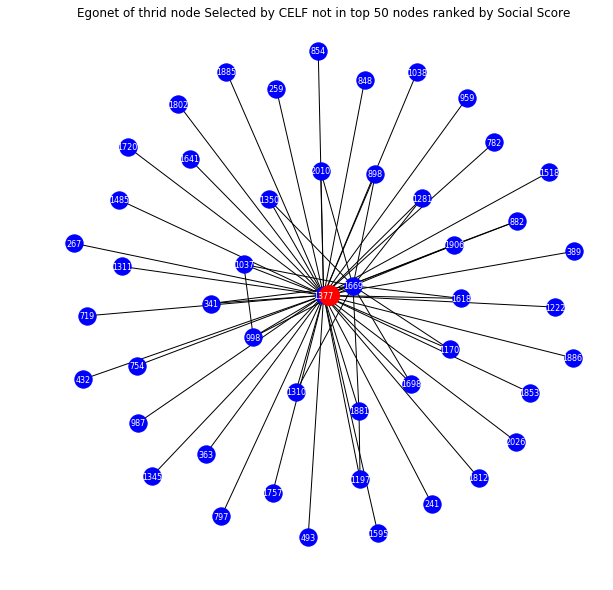

In [41]:
celfOnlyNodes = list()
for n in celfSelected:
    i = topCELFNodes.index(n)
    celfOnlyNodes.append(i)

celfOnlyNodes.sort()
print celfOnlyNodes

#nx.draw_networkx(topCELFNodeEgoNet[i], node_color='b', with_labels=True, font_size=8, font_color='w')
print "Nodes CELF picked that aren't in top 50 Social Score set \n%r" % [topCELFNodes[i] for i in celfOnlyNodes]

plt.figure(figsize=(10,10))
limits=plt.axis('off')
plt.title("Egonet of first node Selected by CELF not in top 50 nodes ranked by Social Score ")
pos = nx.spring_layout(topCELFNodeEgoNet[celfOnlyNodes[0]], iterations=100)
nx.draw_networkx(topCELFNodeEgoNet[celfOnlyNodes[0]], node_color='b', with_labels=True, font_size=8, font_color='w')
nx.draw_networkx_nodes(topCELFNodeEgoNet[celfOnlyNodes[0]], pos, nodelist=[topCELFNodes[celfOnlyNodes[0]]], node_size=400, node_color='r', font_color='black')
plt.show()

plt.figure(figsize=(10,10))
limits=plt.axis('off')
pos = nx.spring_layout(topCELFNodeEgoNet[celfOnlyNodes[1]], iterations=100)
plt.title("Egonet of second node Selected by CELF not in top 50 nodes ranked by Social Score ")
nx.draw_networkx(topCELFNodeEgoNet[celfOnlyNodes[1]], node_color='b', with_labels=True, font_size=8, font_color='w')
nx.draw_networkx_nodes(topCELFNodeEgoNet[celfOnlyNodes[1]], pos, nodelist=[topCELFNodes[celfOnlyNodes[1]]], node_size=400, node_color='r', font_color='black')
plt.show()

plt.figure(figsize=(10,10))
limits=plt.axis('off')
plt.title("Egonet of thrid node Selected by CELF not in top 50 nodes ranked by Social Score")
pos = nx.spring_layout(topCELFNodeEgoNet[celfOnlyNodes[2]], iterations=100)
nx.draw_networkx(topCELFNodeEgoNet[celfOnlyNodes[2]], node_color='b', with_labels=True, font_size=8, font_color='w')
nx.draw_networkx_nodes(topCELFNodeEgoNet[celfOnlyNodes[2]], pos, nodelist=[topCELFNodes[celfOnlyNodes[2]]], node_size=400, node_color='r', font_color='black')
plt.show()

In [42]:
#
# Print order in which CELF selected Social Score nodes 
celfOrder = list()
for n in topCELFNodes:
    if n not in topSocialNodes:
        continue
    celfOrder.append(topSocialNodes.index(n) + 1)
print "CELF picked top 50 Social Score nodes in following order: \n%r" % celfOrder

CELF picked top 50 Social Score nodes in following order: 
[1, 4, 12, 21, 15, 22, 23, 2, 27, 45, 3, 47, 5, 30, 34, 41, 42, 49, 29, 8, 16, 17, 28, 10, 14, 44, 24, 6, 9, 32, 26]


In [43]:
#
# Print Ranking of Nodes Selected by CELF that aren't in top N Social Score nodes 
#
celfOnlyOrder = list()
# Print order in which CELF selected Social Score nodes 

allNodes = [int(n) for n, v in socialNodes]
for i, n in enumerate(celfSelected):
    if n not in allNodes:
        continue
    celfOnlyOrder.append((celfOnlyNodes[i],(allNodes.index(n) + 1)))
    
print "CELF picked nodes not in top 50\n%r" % celfOnlyOrder


CELF picked nodes not in top 50
[(12, 963), (14, 68), (16, 72), (20, 163), (23, 134), (24, 1015), (27, 124), (28, 58), (29, 70), (34, 63), (35, 67), (36, 564), (38, 61), (39, 123), (40, 85), (43, 238), (44, 66), (47, 51), (48, 994)]


In [44]:
#
# Load social score nodes 
#
nodeFeatures = dict()

with open('../results/nodeSocialScoreFeature.txt', 'r') as fd:
    reader = csv.reader(fd, delimiter=',')            
    for row in reader:
        #print row
        nodeFeatures[row[0]] = [row[4], row[5], row[6] ] 
        

In [45]:
for i, n in enumerate(celfSelected):
    print "CELF Order: %d, Node: %d, #clique: %r, #rawClique: %r, weighted:%r" % \
        (celfOnlyNodes[i], n, nodeFeatures[str(n)][0], nodeFeatures[str(n)][1], nodeFeatures[str(n)][2])

CELF Order: 12, Node: 1952, #clique: '8', #rawClique: '40', weighted:'0.0'
CELF Order: 14, Node: 1377, #clique: '10', #rawClique: '56', weighted:'0.0'
CELF Order: 16, Node: 547, #clique: '8', #rawClique: '32', weighted:'0.0'
CELF Order: 20, Node: 390, #clique: '0.0', #rawClique: '0.0', weighted:'0.0'
CELF Order: 23, Node: 1510, #clique: '6', #rawClique: '164', weighted:'0.0'
CELF Order: 24, Node: 1254, #clique: '0.0', #rawClique: '0.0', weighted:'0.0'
CELF Order: 27, Node: 841, #clique: '8', #rawClique: '240', weighted:'0.0'
CELF Order: 28, Node: 419, #clique: '1', #rawClique: '8', weighted:'0.0'
CELF Order: 29, Node: 1906, #clique: '12', #rawClique: '148', weighted:'0.0'
CELF Order: 34, Node: 691, #clique: '21', #rawClique: '2360', weighted:'0.0'
CELF Order: 35, Node: 1876, #clique: '6', #rawClique: '120', weighted:'0.0'
CELF Order: 36, Node: 246, #clique: '8', #rawClique: '36', weighted:'0.0'
CELF Order: 38, Node: 329, #clique: '18', #rawClique: '464', weighted:'0.0'
CELF Order: 39, 

## Community Detection

In [46]:
scc_community = greedy_modularity_communities(SCC)

In [47]:
scc_comm_social_nodes = list()
scc_comm_celf_nodes = list()

for i, community in enumerate(scc_community):
    community_node_set = set(community)
    social_nodes_in_community = topSocialNodeSet.intersection(community_node_set)
    celf_nodes_in_community = topCELFNodeSet.intersection(community_node_set)
    print "Commuinity[%d] size: %d" % (i, len(community_node_set))
    #print "Social Score Nodes found in community[%d]: %d" % (i, len(social_nodes_in_community))
    scc_comm_social_nodes.append((i, len(social_nodes_in_community)))
    #print "CELF Nodes found in community[%d]: %d" % (i, len(celf_nodes_in_community))
    scc_comm_celf_nodes.append((i, len(celf_nodes_in_community)))

Commuinity[0] size: 442
Commuinity[1] size: 367
Commuinity[2] size: 323
Commuinity[3] size: 276
Commuinity[4] size: 226
Commuinity[5] size: 107
Commuinity[6] size: 38
Commuinity[7] size: 20
Commuinity[8] size: 5
Commuinity[9] size: 5
Commuinity[10] size: 4
Commuinity[11] size: 4
Commuinity[12] size: 4
Commuinity[13] size: 4
Commuinity[14] size: 3
Commuinity[15] size: 3
Commuinity[16] size: 2


In [48]:
socialNodeCommunity = list()

for n in topSocialNodes:
    for i, community in enumerate(scc_community):
        if n in community:
            socialNodeCommunity.append((n, i+1))
            
print "Social Node to community mapping:\n%r" % socialNodeCommunity[:20]

Social Node to community mapping:
[(1874, 2), (1258, 3), (999, 3), (1669, 4), (511, 3), (1998, 3), (585, 3), (1440, 3), (852, 3), (1278, 3), (1974, 3), (453, 1), (1580, 3), (411, 3), (1159, 1), (1839, 3), (1369, 3), (737, 3), (1894, 3), (1522, 3)]


In [49]:
celfNodeCommunity = list()

for n in topCELFNodes:
    for i, community in enumerate(scc_community):
        n = int(n)
        if n in community:
            celfNodeCommunity.append((n, i+1))          

print "CELF Node to community mapping:\n%r" % celfNodeCommunity[:20]

CELF Node to community mapping:
[(1874, 2), (1669, 4), (453, 1), (1706, 2), (1159, 1), (1144, 3), (1287, 1), (1258, 3), (895, 1), (278, 1), (999, 3), (993, 5), (1274, 7), (511, 3), (246, 5), (412, 3), (1377, 5), (1, 6), (465, 3), (203, 3)]


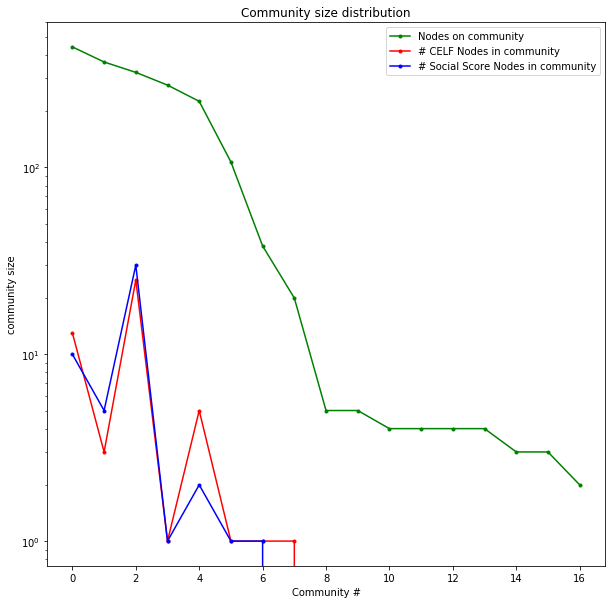

In [50]:
scc_community_size = [len(c) for c in scc_community]
yc = [s for i, s in scc_comm_celf_nodes]
ys = [s for i, s in scc_comm_social_nodes]

plt.figure(figsize=(10,10))
plt.yscale('log')
plt.plot(scc_community_size, 'g', marker='.')
plt.plot(yc, 'r', marker='.')
plt.plot(ys, 'b', marker='.')
plt.legend(['Nodes on community',  '# CELF Nodes in community', '# Social Score Nodes in community'])
plt.xlabel('Community #')
plt.ylabel('community size')
plt.title("Community size distribution")
plt.show()

In [161]:
cmaps = ['blue', 'green', 'orange', 'red', 'cyan', 'grey', 'yellow', 'brown']

egonet_size = [len(v) for k, v in topCELFNodeEgoNet.iteritems()]
minNodeSize = min(egonet_size)
maxNodeSize = max(egonet_size)

print minNodeSize, maxNodeSize

#
# Get EgoNets of CELF Nodes 
#
celfNodeEgonet = dict()
celfNodeMapColor = dict()
celfNodeSize = dict()
celfNodeCommunity.sort(key=lambda x: (x[1], [x[0]]))
celfNodeCommDict = dict()

for node, community in celfNodeCommunity:
    egoGraph = nx.ego_graph(uGNx, node, radius=1, undirected=True) 
    egonetNodeList = list(egoGraph.nodes())
    nodeSize = min(float(150)*((maxNodeSize + 1)/(len(egonetNodeList) - minNodeSize + 1)), 800)
    celfNodeEgonet[node] = egonetNodeList
    celfNodeSize[node] = nodeSize
    celfNodeMapColor[node] = cmaps[community-1]
    celfNodeCommDict[node] = community

print celfNodeMapColor[1874]

10 403
green


In [243]:

celfGNx = nx.Graph()
for (src, _) in celfNodeCommunity:
    for (dst, _) in celfNodeCommunity:
        if src == dst:
            continue

        edge_count = uGNx.number_of_edges(src, dst)
        
        if edge_count > 0:
            celfGNx.add_edge(src, dst)
            pass

In [268]:
#
# Shell based on social score 
# 
shellDict = dict()

#
# group nodes based on social ranking 
# 
s0 = 0
s1 = 1
s2 = s1 + 7
s3 = s2 + 14
s4 = s3 + 28
s5 = s4 + 35
s6 = s5 + 42

#
# Create a place holder for nodes at each layer 
#
shellHierarchy = [s0, s1, s2, s3, s4, s5, s6]
for s in shellHierarchy:
    shellDict[s] = list()

for n, c in celfNodeCommunity:
    s_index = allSocialNodes.index(n)
    
    if s_index - s6 >= 0:
        shellDict[s6].append(n)
    elif s_index - s5 >= 0:
        shellDict[s5].append(n)
    elif s_index - s4 >= 0:
        shellDict[s4].append(n)
    elif s_index - s3 >= 0:
        shellDict[s3].append(n)
    elif s_index - s2 >= 0:
        shellDict[s2].append(n)
    elif s_index - s1 >= 0:
        shellDict[s1].append(n)
    else:
        shellDict[s0].append(n)
        
shells = list()
for s, nodes in shellDict.iteritems():
    shells.append(nodes)
    
#shells.sort(reverse=True)
print shells
pos = nx.shell_layout(celfGNx, shells)
node_color = list()
node_size = list()
for node in celfGNx:
    node_color.append(celfNodeMapColor[node])
    node_size.append(celfNodeSize[node])

[[1874], [511, 999, 1258, 1440, 1998, 1669], [453, 1159, 1706, 411, 852, 1144, 1278, 1369, 1839], [329, 691, 1876, 1906, 350, 419, 829, 547, 1377, 1274], [24, 841], [278, 713, 869, 895, 1287, 1768, 203, 412, 465, 1198, 1586, 1792, 1963, 993, 1], [1500, 390, 1151, 1510, 246, 1952, 1254]]


## CELF Spring/shell visualization

[0. 0.]


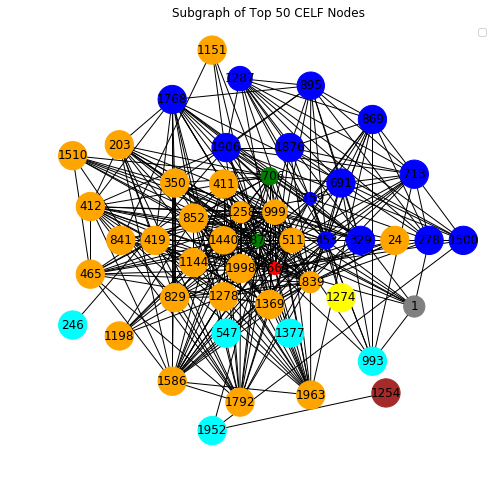

In [269]:
#pos = nx.spring_layout(celfGNx)
print pos[1874]
plt.figure(figsize=(8,8))
limits=plt.axis('off')
plt.title('Subgraph of Top 50 CELF Nodes')
plt.legend(['radial distance propotional to social score'])
nx.draw_networkx(celfGNx, pos=pos, node_size=node_size, node_color=node_color, with_labels=True)
plt.show()

## CELF Custom visualization

In [301]:
celfCustPos = nx.shell_layout(celfGNx, shells)
y = 1.0
for nlist in shells:
    length = float(len(nlist))
    mid = length/2.0
    y -= 0.1
    for i, n in enumerate(nlist):
        #pos[n][0] = y*(1.0/socialNodeCommDict[n])
        celfCustPos[n][0] = 2.0 + 3*(float(i+1)- mid)/length
        s = socialScoreDict[n]
        s = s*2 + 0.25*(10**(min((1.0 - s),0.5)))
        celfCustPos[n][1] = y

celfCustPos[1874]

array([3.5, 0.9])

In [302]:
celf_cust_node_color = list()
celf_cust_node_size = list()
for node in celfGNx:
    celf_cust_node_color.append(celfNodeMapColor[node])
    celf_cust_node_size.append(celfNodeSize[node])

In [303]:
#print socialNodes[:10]
print  socialScoreDict[1254]
print  celfNodeCommDict[1874]
print  celfNodeMapColor[1874] 

0.0174825085611
2
green


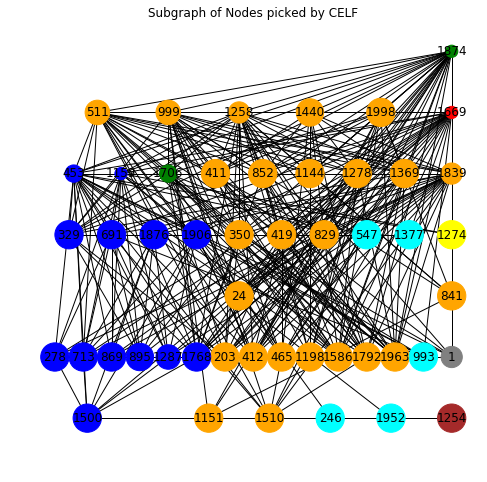

In [305]:
plt.figure(figsize=(8,8))
#pos=nx.spring_layout(celfGNx, iterations=500)
limits=plt.axis('off')

#pos = nx.kamada_kawai_layout(celfGNx, pos=pos)
plt.title('Subgraph of Nodes picked by CELF')
nx.draw_networkx(celfGNx, pos=celfCustPos, node_size=celf_cust_node_size, node_color=celf_cust_node_color, with_labels=True)
plt.savefig('subgraphCELF')
plt.show()

In [537]:
print "Average clustering of CELF node: %r" % nx.average_clustering(celfGNx)

Average clustering of CELF node: 0.6289460272945637


In [213]:
cmaps = ['blue', 'green', 'orange', 'red', 'cyan', 'grey', 'yellow', 'brown']

s_egonet_size = [len(v) for k, v in topSocialNodeEgonet.iteritems()]
minNodeSize = min(s_egonet_size)
maxNodeSize = max(s_egonet_size)

print minNodeSize, maxNodeSize

#
# Get EgoNets of Social Nodes 
#
socialNodeEgonet = dict()
socialNodeMapColor = dict()
socialNodeSize = dict()
socialNodeCommunity.sort(key=lambda x: (x[1], [x[0]]))
socialNodeCommDict = dict()

for node, community in socialNodeCommunity:
    egoGraph = nx.ego_graph(uGNx, node, radius=1, undirected=True) 
    egonetNodeList = list(egoGraph.nodes())
    nodeSize = min(float(150)*((maxNodeSize + 1)/(len(egonetNodeList) - minNodeSize + 1)), 800)
    socialNodeEgonet[node] = egonetNodeList
    socialNodeSize[node] = nodeSize
    socialNodeMapColor[node] = cmaps[community-1]
    socialNodeCommDict[node] = community

print socialNodeMapColor[1874]

2 403
green


In [258]:

socialGNx = nx.Graph()
for (src, _) in socialNodeCommunity:
    for (dst, _) in socialNodeCommunity:
        if src == dst:
            continue

        edge_count = uGNx.number_of_edges(src, dst)
        
        if edge_count > 0:
            socialGNx.add_edge(src, dst)
            pass

In [310]:
#
# Shell based on social score 
# 
socialShellDict = dict()

#
# group nodes based on social ranking 
# 
s0 = 0
s1 = 1
s2 = s1 + 7
s3 = s2 + 14
s4 = s3 + 28
s5 = s4 + 35
s6 = s5 + 42

#
# Create a place holder for nodes at each layer 
#
socialShellHierarchy = [s0, s1, s2, s3, s4, s5, s6]
for s in socialShellHierarchy:
    socialShellDict[s] = list()

for n, c in socialNodeCommunity:
    s_index = allSocialNodes.index(n)
    
    if s_index - s6 >= 0:
        socialShellDict[s6].append(n)
    elif s_index - s5 >= 0:
        socialShellDict[s5].append(n)
    elif s_index - s4 >= 0:
        socialShellDict[s4].append(n)
    elif s_index - s3 >= 0:
        socialShellDict[s3].append(n)
    elif s_index - s2 >= 0:
        socialShellDict[s2].append(n)
    elif s_index - s1 >= 0:
        socialShellDict[s1].append(n)
    else:
        socialShellDict[s0].append(n)
        
socialShells = list()
for s, nodes in socialShellDict.iteritems():
    if not nodes: 
        continue
    socialShells.append(nodes)
    
#shells.sort(reverse=True)
print socialShells
socialPos = nx.shell_layout(socialGNx, socialShells)
social_node_color = list()
social_node_size = list()
for node in socialGNx:
    social_node_color.append(socialNodeMapColor[node])
    social_node_size.append(socialNodeSize[node])

[[1874], [511, 585, 999, 1258, 1440, 1998, 1669], [453, 1159, 1706, 411, 737, 852, 1144, 1278, 1369, 1522, 1580, 1839, 1894, 1974], [278, 713, 869, 895, 1277, 1287, 1768, 1987, 301, 984, 1753, 34, 203, 217, 412, 465, 1198, 1501, 1586, 1587, 1792, 1833, 1844, 1963, 480, 993, 1, 1301]]


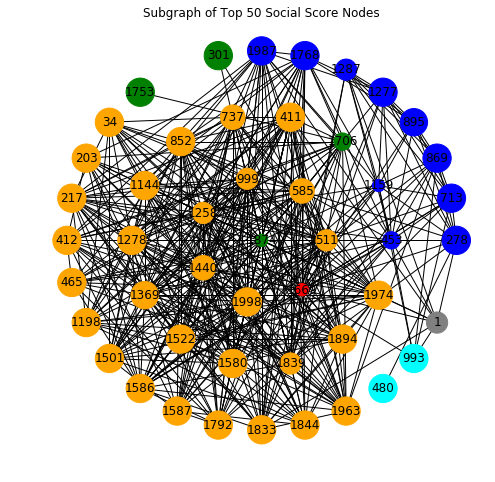

In [271]:
plt.figure(figsize=(8,8))
limits=plt.axis('off')
plt.title('Subgraph of Top 50 Social Score Nodes')
nx.draw_networkx(socialGNx, pos=socialPos, node_size=social_node_size, node_color=social_node_color, with_labels=True)
plt.show()

## Social Node Custom visualization


In [311]:
social_cust_pos = nx.shell_layout(socialGNx, socialShells)

y = 1.0
for nlist in socialShells:
    length = float(len(nlist))
    mid = length/2.0
    y -= 0.2
    for i, n in enumerate(nlist):
        #pos[n][0] = y*(1.0/socialNodeCommDict[n])
        social_cust_pos[n][0] = 2.0 + 3*(float(i+1)- mid)/length
        s = socialScoreDict[n]
        s = s*2 + 0.25*(10**(min((1.0 - s),0.5)))
        social_cust_pos[n][1] = y

In [312]:
social_cust_node_color = list()
social_cust_node_size = list()
for node in socialGNx:
    social_cust_node_color.append(socialNodeMapColor[node])
    social_cust_node_size.append(socialNodeSize[node])

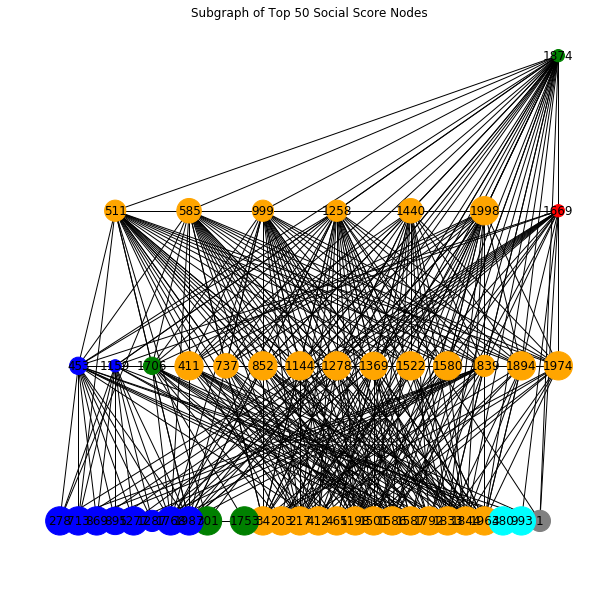

In [314]:
plt.figure(figsize=(10,10))
limits=plt.axis('off')
plt.title('Subgraph of Top 50 Social Score Nodes')
nx.draw_networkx(socialGNx, pos=social_cust_pos, node_size=social_cust_node_size, node_color=social_cust_node_color, with_labels=True)
plt.show()

## Graphviz 

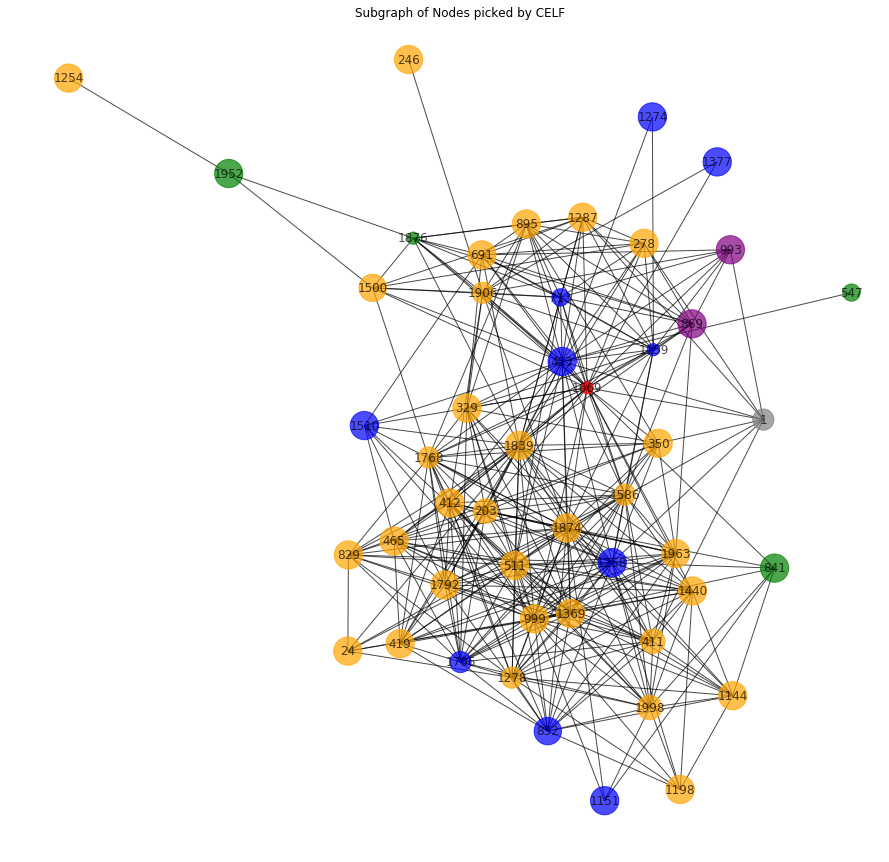

In [602]:
try:
    import pygraphviz
    from networkx.drawing.nx_agraph import graphviz_layout
except ImportError:
    try:
        import pydot
        from networkx.drawing.nx_pydot import graphviz_layout
    except ImportError:
        raise ImportError("This example needs Graphviz and either "
                          "PyGraphviz or pydot")

pos = graphviz_layout(celfGNx, prog='neato', args='')

plt.figure(figsize=(15, 15))
plt.title('Subgraph of Nodes picked by CELF')
limits=plt.axis('off')
nx.draw(celfGNx, pos, node_size=node_size, alpha=0.7, node_color=node_color, with_labels=True)
plt.axis('equal')
plt.show()

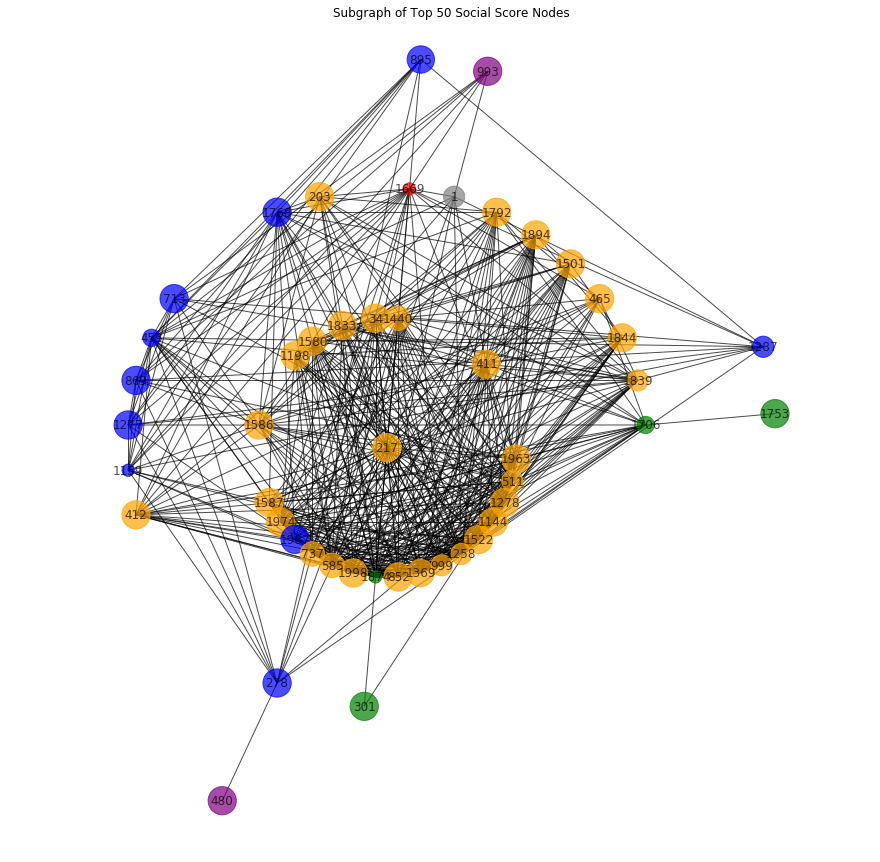

In [600]:
try:
    import pygraphviz
    from networkx.drawing.nx_agraph import graphviz_layout
except ImportError:
    try:
        import pydot
        from networkx.drawing.nx_pydot import graphviz_layout
    except ImportError:
        raise ImportError("This example needs Graphviz and either "
                          "PyGraphviz or pydot")

pos = graphviz_layout(socialGNx, prog='twopi', args='')
#pos = graphviz_layout(socialGNx, prog='dot', args='')

plt.figure(figsize=(15, 15))
limits=plt.axis('off')
plt.title('Subgraph of Top 50 Social Score Nodes')
nx.draw(socialGNx, pos, node_size=node_size, alpha=0.7, node_color=node_color, with_labels=True)
plt.axis('equal')
plt.show()

## Bridge links in SCC 


In [606]:
bridge_list = list(nx.bridges(SCC))

In [633]:
print "SCC %d bridge links" % len(bridge_list)
#print bridge_list[:10]
nMap = dict()
for (src, dst) in bridge_list:
    if SCC.degree(src) == 1 and SCC.degree(dst) == 1:
        continue
        
    if SCC.degree(src) == 1:
        n1 = dst
        n2 = src
    else:
        n1 = src
        n2 = dst
    
    if n1 not in nMap:
        nMap[n1] = list()
    nMap[n1].append(n2)
    

SCC 1177 bridge links


In [641]:
for n in nMap.keys():
    if SCC.degree(n) > 1:
        continue

print "SCC has %d bridge Nodes" % len(nMap.keys())
bridgeNodes = [n for n in nMap.keys()]
bridgeNodeSet = set(bridgeNodes)
print "%d Social nodes are bridge nodes:" % len(bridgeNodeSet.intersection(topSocialNodeSet))
print "%d CELF nodes are bridge nodes:" % len(bridgeNodeSet.intersection(topCELFNodeSet))

SCC has 117 bridge Nodes
26 Social nodes are bridge nodes:
35 CELF nodes are bridge nodes:


## Spectral Analysis 


In [609]:
L_norm = nx.normalized_laplacian_matrix(SCC)

In [642]:
fiedler_vector = nx.fiedler_vector(SCC)

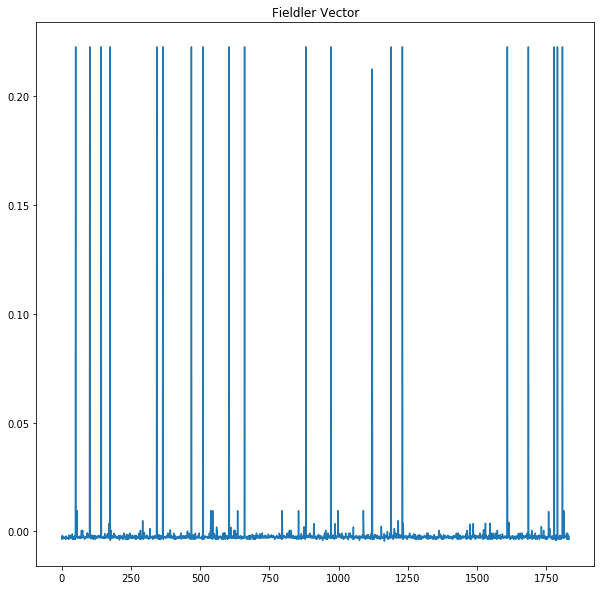

In [643]:
fiedler_list = fiedler_vector.tolist()
plt.figure(figsize=(10,10))
plt.title("Fieldler Vector")
plt.yscale('linear')
plt.plot(fiedler_list)
plt.show()

In [610]:
eigen_values = nx.laplacian_spectrum(SCC)

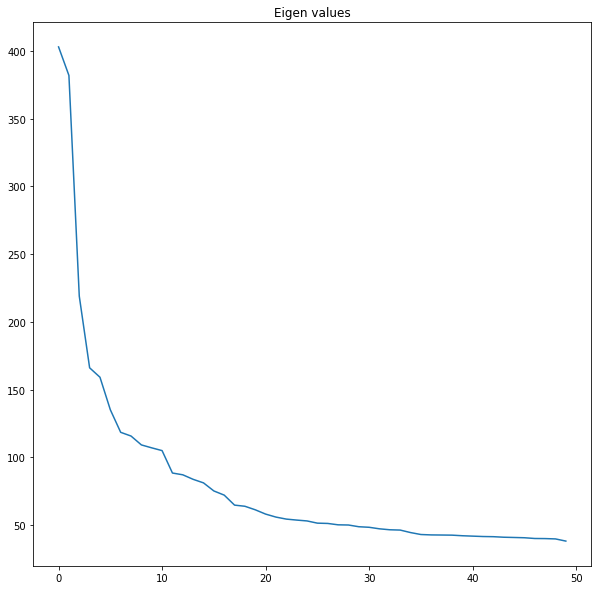

In [620]:
eigen_list = eigen_values.tolist()
eigen_list.sort(reverse=True)
plt.figure(figsize=(10,10))
plt.title("Eigen values")
plt.yscale('linear')
plt.plot(eigen_list[:50])
plt.show()

[80.78021754303406, 55.4659080081707, 51.65134719039465, 42.936504335383276, 41.144926456992756, 38.94771394756082, 38.78737308016589, 34.7177822103923, 27.237611856350544, 26.892696751894427]


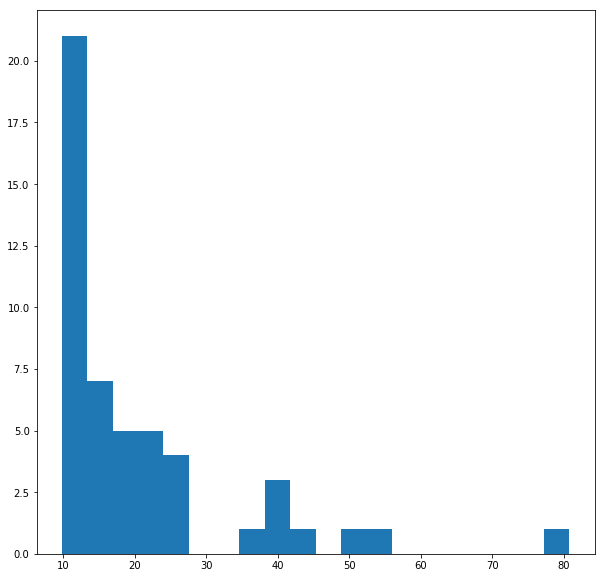

In [123]:
xx = [ float(s) for n, s in socialNodes]
print xx[:10]
plt.figure(figsize=(10,10))
plt.hist(xx[:50], bins=20)
plt.show()

In [131]:
nx.write_gexf(celfGNx, "celf.gexf")
nx.write_gexf(socialGNx, "social.gexf")